In [584]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_colwidth', None)

In [585]:
##  HYPER PARAMAETERS  ##

TICKER = "KO"
SEQUENCE_NUM = 10

epochs = 10
batch_size = 1
learning_rate = 0.0001

In [586]:
df = pd.read_csv('./datasets/ny_stock.csv')
df = df.loc[(df['symbol'] == TICKER)]
df = df.drop(columns=['date','symbol'])
df = df[['open','close','low','volume','high']]
df

,open,close,low,volume,high
497,28.580000,28.520000,28.450001,13870400.0,28.610001
965,28.424999,28.174999,28.070000,23172400.0,28.495001
1433,28.174999,28.165001,27.990000,19264600.0,28.220000
1901,28.165001,28.095000,27.875000,13234600.0,28.184999
2369,27.730000,27.575001,27.375000,28712400.0,27.820000
...,...,...,...,...,...
849025,41.619999,41.599998,41.349998,6410600.0,41.689999
849525,41.560001,41.610001,41.540001,6986100.0,41.759998
850025,41.490002,41.389999,41.389999,8825600.0,41.669998
850525,41.380001,41.599998,41.380001,6817900.0,41.689999


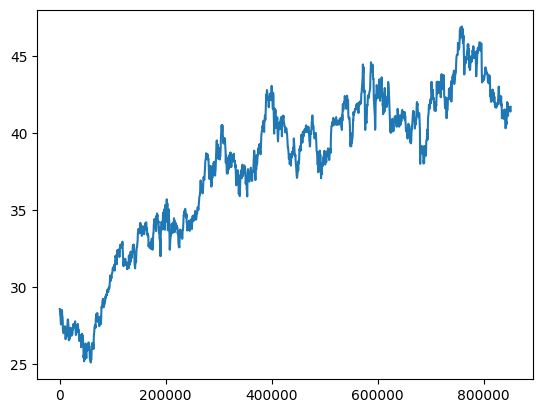

In [587]:
plt.plot(df['open'])
plt.show()

In [588]:
x=np.empty((0, SEQUENCE_NUM, 5))
t=np.empty((0, 5))

for i in range(df.shape[0]-SEQUENCE_NUM-1):
  x=np.append(x, [df.iloc[i:i+SEQUENCE_NUM]], axis=0)
  t=np.append(t, [df.iloc[i+SEQUENCE_NUM+1]], axis=0)

In [589]:
class StockDataset(torch.utils.data.Dataset):
  def __init__(self):
    self.data = torch.Tensor(x)
    self.target = torch.Tensor(t)
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx], self.target[idx]
  
dataset = StockDataset()

data_mean = dataset.data.mean(dim=0, keepdim=True)
data_std = dataset.data.std(dim=0, keepdim=True)

target_mean = dataset.target.mean(dim=0, keepdim=True)
target_std = dataset.target.std(dim=0, keepdim=True)

dataset.data = (dataset.data - data_mean) / (data_std + 1e-7)
dataset.target = (dataset.target - target_mean) / (target_std + 1e-7)

generator = torch.Generator().manual_seed(69)
train, validation, test = torch.utils.data.random_split(dataset, [.7, .2, .1], generator)

train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(validation, batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test, batch_size, shuffle=True)

dataset.data.shape, dataset.target.shape

(torch.Size([1751, 10, 5]), torch.Size([1751, 5]))

In [590]:
class StockNeuralNetwork(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = nn.LSTM(5, 100, 10, batch_first=True)
    self.layers = nn.Sequential(
      nn.Dropout(p=0.3),
      nn.Linear(100, 5)
    )

    self.hn = (
      torch.zeros(1, batch_size, 100),
      torch.zeros(1, batch_size, 100))

  def forward(self, x):
    y, self.hn = self.rnn(x, self.hn)
    y = self.layers(y)
    return y
  
  def refresh_hidden(self):
    weight = next(self.parameters()).data
    self.hn = (
      weight.new(10, batch_size, 100).zero_(),
      weight.new(10, batch_size, 100).zero_())
  
model = StockNeuralNetwork()
model

StockNeuralNetwork(
  (rnn): LSTM(5, 100, num_layers=10, batch_first=True)
  (layers): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=100, out_features=5, bias=True)
  )
)

In [591]:
class EarlyStopper:
  def __init__(self, patience=1, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = float('inf')

  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0
    elif validation_loss > (self.min_validation_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        return True

    return False

In [592]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), learning_rate)
early_stopper = EarlyStopper(patience=3)

for epoch in range(epochs):
  for i, (x, t) in enumerate(train_loader):
    optimizer.zero_grad()
    model.refresh_hidden()
    y = model(x)
    y = y[:,-1,:]
    loss_train = criterion(y, t)
    loss_train.backward()
    optimizer.step()

    if i % 10 == 0:
      for x, t in validation_loader:
        y = model(x)
        y = y[:,-1,:]
        loss_validation = criterion(y, t)
        if early_stopper.early_stop(loss_validation):             
          break

      print(f"Epoch #{epoch}, Batch #{i}, Train Loss: {loss_train.item():.4f}, Validation Loss: {loss_validation.item():.4f}")

Epoch #0, Batch #0, Train Loss: 1.8128, Validation Loss: 4.0417
Epoch #0, Batch #10, Train Loss: 0.5496, Validation Loss: 1.1926
Epoch #0, Batch #20, Train Loss: 0.6713, Validation Loss: 0.7755
Epoch #0, Batch #30, Train Loss: 0.0392, Validation Loss: 0.6779
Epoch #0, Batch #40, Train Loss: 0.8460, Validation Loss: 0.5463
Epoch #0, Batch #50, Train Loss: 0.2251, Validation Loss: 0.7843
Epoch #0, Batch #60, Train Loss: 0.6096, Validation Loss: 0.7542
Epoch #0, Batch #70, Train Loss: 1.0498, Validation Loss: 0.3455
Epoch #0, Batch #80, Train Loss: 0.4963, Validation Loss: 0.5875
Epoch #0, Batch #90, Train Loss: 0.1016, Validation Loss: 0.3706
Epoch #0, Batch #100, Train Loss: 0.3360, Validation Loss: 0.6429
Epoch #0, Batch #110, Train Loss: 0.1472, Validation Loss: 0.3626
Epoch #0, Batch #120, Train Loss: 0.0258, Validation Loss: 0.5088
Epoch #0, Batch #130, Train Loss: 0.6785, Validation Loss: 2.5852
Epoch #0, Batch #140, Train Loss: 0.1636, Validation Loss: 1.0020
Epoch #0, Batch #150,

In [712]:
model.eval()
torch.no_grad()
criterion = torch.nn.MSELoss()

item_count = len(test.indices)
loss_total = 0

for n in range(item_count):
  x = dataset.data[test.indices[n]].reshape(1, 10, 5)
  t = dataset.target[test.indices[n]]

  y = model(x)
  loss = criterion(y, t)
  loss_total += loss.item()

loss_total / item_count

1.559599199837872

In [726]:
model.eval()

x, t=next(iter(test_loader))
t=t * target_std + target_mean

y=model(x)
y=y * target_std + target_mean

y=y[:,-1,:][0][0].item()
t=t[0][0].item()

f"y={y:.4f}, t={t:.4f}"

'y=31.5742, t=30.7450'